*   Network     : ResNet18
*   Optimizer   : ADAM
*   Regularizer : No regularization

Ref for code: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb

In [ ]:
from __future__ import print_function

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras import callbacks

from keras.applications.imagenet_utils import preprocess_input
from keras.datasets import cifar100
from keras.initializers import glorot_uniform
from keras.layers.core import Lambda
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import layer_utils, data_utils, vis_utils, plot_model #data_utils.get_file #vis_utils.model_to_dot

import numpy as np
import pydot
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [ ]:
#Loading cifar100 dataset and dividing into Train, Validation and Test sets

(X_train, Y_train), (x_test, y_test_o) = cifar100.load_data()

X_train = X_train.astype('float32')
x_test = x_test.astype('float32')

x_train, x_validation, y_train, y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

y_train = keras.utils.to_categorical(y_train, 100)
y_validation = keras.utils.to_categorical(y_validation, 100)
y_test = keras.utils.to_categorical(y_test_o, 100)

In [ ]:
#Definition of hyper parameters and other characteristics of the network like the activation functions

num_classes = 100
weight_decay = 0.0005
x_shape = [32,32,3]

conv_activation_func = 'elu'

batch_size = 32
maxepoches = 100
l_rate = 0.0001
lr_decay = 1e-6
# lr_drop = 20

In [ ]:
def identity_block(X, f, filters):
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
    X = Activation(conv_activation_func)(X)

    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
    X = Activation(conv_activation_func)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation(conv_activation_func)(X)
       
    return X

In [ ]:
def convolutional_block(X, f, filters, s = 2):
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (3, 3), strides = (s,s), padding='same')(X)
    X = Activation(conv_activation_func)(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
    X = Activation(conv_activation_func)(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F2, kernel_size = (3, 3), strides = (s,s), padding = 'same')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation(conv_activation_func)(X)
    
    return X

In [ ]:
def ResNet18(input_shape=(32, 32, 3), classes=100):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(X)
    X = Activation(conv_activation_func)(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64], s=1)
    X = identity_block(X, 3, [64, 64])

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128], s = 2)
    X = identity_block(X, 3, [128, 128])

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256], s = 2)
    X = identity_block(X, 3, [256, 256])

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512], s = 2)
    X = identity_block(X, 3, [512, 512])

    # AVGPOOL
    X = AveragePooling2D((2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = ResNet18(input_shape = (32, 32, 3), classes = 100)

In [ ]:
#Definition of ADAM optimizer
adam = optimizers.Adam(learning_rate=l_rate)

#Compiling the model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [ ]:
#Defintion of callbacks with EarlyStopping 

callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
#Definition of saving the best weights of the model with ModelCheckpoint

checkpoint_path = "checkpoints"
checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1, mode='min')

In [ ]:
#Training the model in the training dataset

history = model.fit(datagen.flow(x_train, y_train), epochs = maxepoches, batch_size = batch_size, validation_data=(x_validation, y_validation), callbacks=[callback, checkpoint])
model.save_weights('ResNet18_ADAM_NoRegularization.h5')

Epoch 1/100
1248/1250 [============================>.] - ETA: 0s - loss: 3.8180 - accuracy: 0.1365
Epoch 00001: val_loss improved from inf to 3.32110, saving model to checkpoints
1250/1250 [==============================] - 33s 27ms/step - loss: 3.8177 - accuracy: 0.1365 - val_loss: 3.3211 - val_accuracy: 0.2025
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 3.1366 - accuracy: 0.2316
Epoch 00002: val_loss improved from 3.32110 to 2.88553, saving model to checkpoints
1250/1250 [==============================] - 33s 26ms/step - loss: 3.1366 - accuracy: 0.2316 - val_loss: 2.8855 - val_accuracy: 0.2838
Epoch 3/100
1248/1250 [============================>.] - ETA: 0s - loss: 2.8661 - accuracy: 0.2823
Epoch 00003: val_loss did not improve from 2.88553
1250/1250 [==============================] - 32s 26ms/step - loss: 2.8662 - accuracy: 0.2822 - val_loss: 2.9157 - val_accuracy: 0.2831
Epoch 4/100
1249/1250 [============================>.] - ETA: 0s - loss: 2.6615 - a

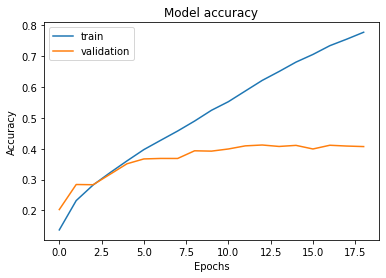

In [ ]:
#Plot the Training and Validation accuracy v/s Epochs
#history.keys() = ['accuracy', 'loss', 'val_accuracy', 'val_loss']

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

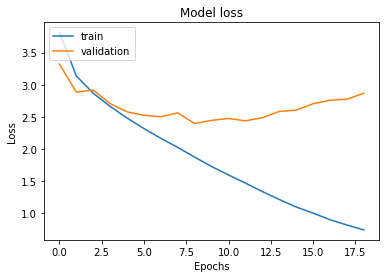

In [ ]:
#Plot the Training and Validation loss v/s Epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#Testing the model using the best weights of the model

model_test = ResNet18(input_shape = (32, 32, 3), classes = 100)
model_test.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_test.load_weights('./ResNet18_ADAM_NoRegularization.h5')
loss, acc = model_test.evaluate(x_test,  y_test, verbose=2)

predict_y_test_o = model_test.predict(x_test, verbose=0)

313/313 - 2s - loss: 2.8119 - accuracy: 0.4220


In [ ]:
# #Precision, recall and accuracy of the model on test data
predict_y_test = np.argmax(predict_y_test_o, axis=1)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_o, predict_y_test)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test_o, predict_y_test, average='macro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test_o, predict_y_test, average='macro')
print('Recall: %f' % recall)

# Confusion matrix
confusion_matrix_ = confusion_matrix(y_test_o, predict_y_test)
print(confusion_matrix_)

Accuracy: 0.422000
Precision: 0.442704
Recall: 0.422000
[[69  1  0 ...  0  1  0]
 [ 1 61  0 ...  0  0  0]
 [ 0  0 20 ...  0  5  0]
 ...
 [ 0  1  0 ... 44  2  0]
 [ 0  1  0 ...  1 26  0]
 [ 0  0  0 ...  0  0 29]]


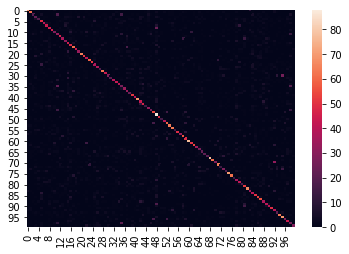

In [ ]:
import seaborn as sb
heat_map = sb.heatmap(confusion_matrix_)
plt.show()